# Predictive Customer Cancellation Model for a Subscription Service

**Notebook Chapters**

*   Project Introduction

*   Model Selection

*   Enviornment Creation

*   Data Ingestion

*   Exploratory Data Analysis

*   Model Comparison

*   Feature Importance

*   Model Interpretation and Conclusions

## Project Introduction

The project uses data from a subscription service to indentify factors and their importance in reducing customer service cancellations (aka, "churn"). Data has been carefully pre-processed to remove Personally Identifiable Information as well as information specific to the business.

For this excercise, multiple measures/features were included across the customer experience to identify potential correlations with churn, and opportunities that span an organization.


*   **'target'**: Boolean value for a customer that churned
*   **'customer_demo_age'**: Customer age
*   **'customer_demo_geography'**: Customer residential location
*   **'sales_channel'**: How the customer purchased their service
*   **'sales_team'**: Affiliate team responsible for the sale
*   **'sales_program'**: Can be infered as the marketing offer
*   **'product_sku'**: Specifics of pricing and packaging
*   **'product_cpe'**: Customer premise equipment
*   **'product_operations_kpi1'**: Measure of operational execution
*   **'product_operations_kpi2'**: Measure of operational execution
*   **'product_usage_kpi1'**: Measure of customer enagement
*   **'product_usage_kpi2'**: Measure of customer enagement
*   **'product_usage_kpi3'**: Measure of customer enagement

## Model Selection

Mutiple models where consdiered for this project. Given the constraints of low compute costs, a small dataset, class imbalance and the need to identify feature weights, the following models were used:

*   Logistic Regression<br>
Pros: With a small dataset and limited compute resources, logistic regression is a great starting point due to its simplicity and low computational cost. It also provides direct insight into feature importance.<br>
Cons: Its linear nature might not capture complex relationships.<br>
<br>
*   Decision Trees<br>
Pros: They are relatively simple to understand and can provide clear insights into which features are most important in predicting churn.<br>
Cons: Prone to overfitting, especially with small datasets.<br>
<br>
*   Random Forest<br>
Pros: Can handle imbalanced classes better than many models and provides feature importance. It's also less likely to overfit compared to a single decision tree.<br>
Cons: More computationally intensive than logistic regression or a single decision<br>
<br>
*   Gradient Boosting Machines <br>
Pros: Often more effective than random forests, especially with small datasets. Provides feature importance.<br>
Cons: Can be computationally expensive and prone to overfitting.<br>
<br>

Results for all models are shown and compared below.

## Enviornment Creation

In [34]:
# Create python enviornment

# Install libraries

!pip install --upgrade pip
!pip install scikit-learn
!pip install pandas==1.5.3 # to be compatible with google-colab 1.0.0
!pip install matplotlib
!pip install shap
!pip install seaborn
# Install methods

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore FutureWarning

import os

import boto3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import f_oneway

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score, accuracy_score,f1_score


## Data Ingestion

In [35]:
# Load CSV data file into a dataframe

bucket_name = 'elgasd'
file_name = 'Data_sets/subscription/telco_subscription_data.csv'

s3_client = boto3.client('s3')

response = s3_client.get_object(Bucket=bucket_name, Key=file_name)

# Read the CSV data from S3 into a Pandas DataFrame
df_pre = pd.read_csv(response['Body'])

df_pre.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134575 entries, 0 to 134574
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   target                   134575 non-null  int64  
 1   customer_demo_age        134575 non-null  int64  
 2   customer_demo_geography  134575 non-null  int64  
 3   sales_channel            134575 non-null  int64  
 4   sales_team               134575 non-null  int64  
 5   sales_program            134575 non-null  int64  
 6   product_sku              134575 non-null  int64  
 7   product_cpe              134575 non-null  int64  
 8   product_operations_kpi1  132071 non-null  float64
 9   product_operations_kpi2  134575 non-null  int64  
 10  product_usage_kpi1       134575 non-null  int64  
 11  product_usage_kpi2       134575 non-null  int64  
 12  product_usage_kpi3       134575 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 13.3 MB


In [36]:
# Address null values

# Look for Nulls

df_pre.info()

# Drop Nulls

df_pre.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134575 entries, 0 to 134574
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   target                   134575 non-null  int64  
 1   customer_demo_age        134575 non-null  int64  
 2   customer_demo_geography  134575 non-null  int64  
 3   sales_channel            134575 non-null  int64  
 4   sales_team               134575 non-null  int64  
 5   sales_program            134575 non-null  int64  
 6   product_sku              134575 non-null  int64  
 7   product_cpe              134575 non-null  int64  
 8   product_operations_kpi1  132071 non-null  float64
 9   product_operations_kpi2  134575 non-null  int64  
 10  product_usage_kpi1       134575 non-null  int64  
 11  product_usage_kpi2       134575 non-null  int64  
 12  product_usage_kpi3       134575 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 13.3 MB


In [37]:
# Identify continuous vs categorical features
# based on count of unique values

for column in df_pre.columns:
    # Get the unique count of the current column
    unique_count = df_pre[column].nunique()
    print(f"Unique values in '{column}': {unique_count}")

feature_cat = ['target',
           'customer_demo_geography',
           'sales_channel',
           'sales_team',
           'sales_program',
           'product_sku',
           'product_cpe']

feature_con = ['customer_demo_age',
           'product_operations_kpi1',
           'product_operations_kpi2',
           'product_usage_kpi1',
           'product_usage_kpi2',
           'product_usage_kpi3']

df_pre[feature_cat] = df_pre[feature_cat].astype(object)
df_pre[feature_con] = df_pre[feature_con].astype(int)

Unique values in 'target': 2
Unique values in 'customer_demo_age': 86
Unique values in 'customer_demo_geography': 50
Unique values in 'sales_channel': 4
Unique values in 'sales_team': 22
Unique values in 'sales_program': 20
Unique values in 'product_sku': 3
Unique values in 'product_cpe': 18
Unique values in 'product_operations_kpi1': 54
Unique values in 'product_operations_kpi2': 27
Unique values in 'product_usage_kpi1': 14209
Unique values in 'product_usage_kpi2': 3439
Unique values in 'product_usage_kpi3': 2634


## Exploratory Data Analysis

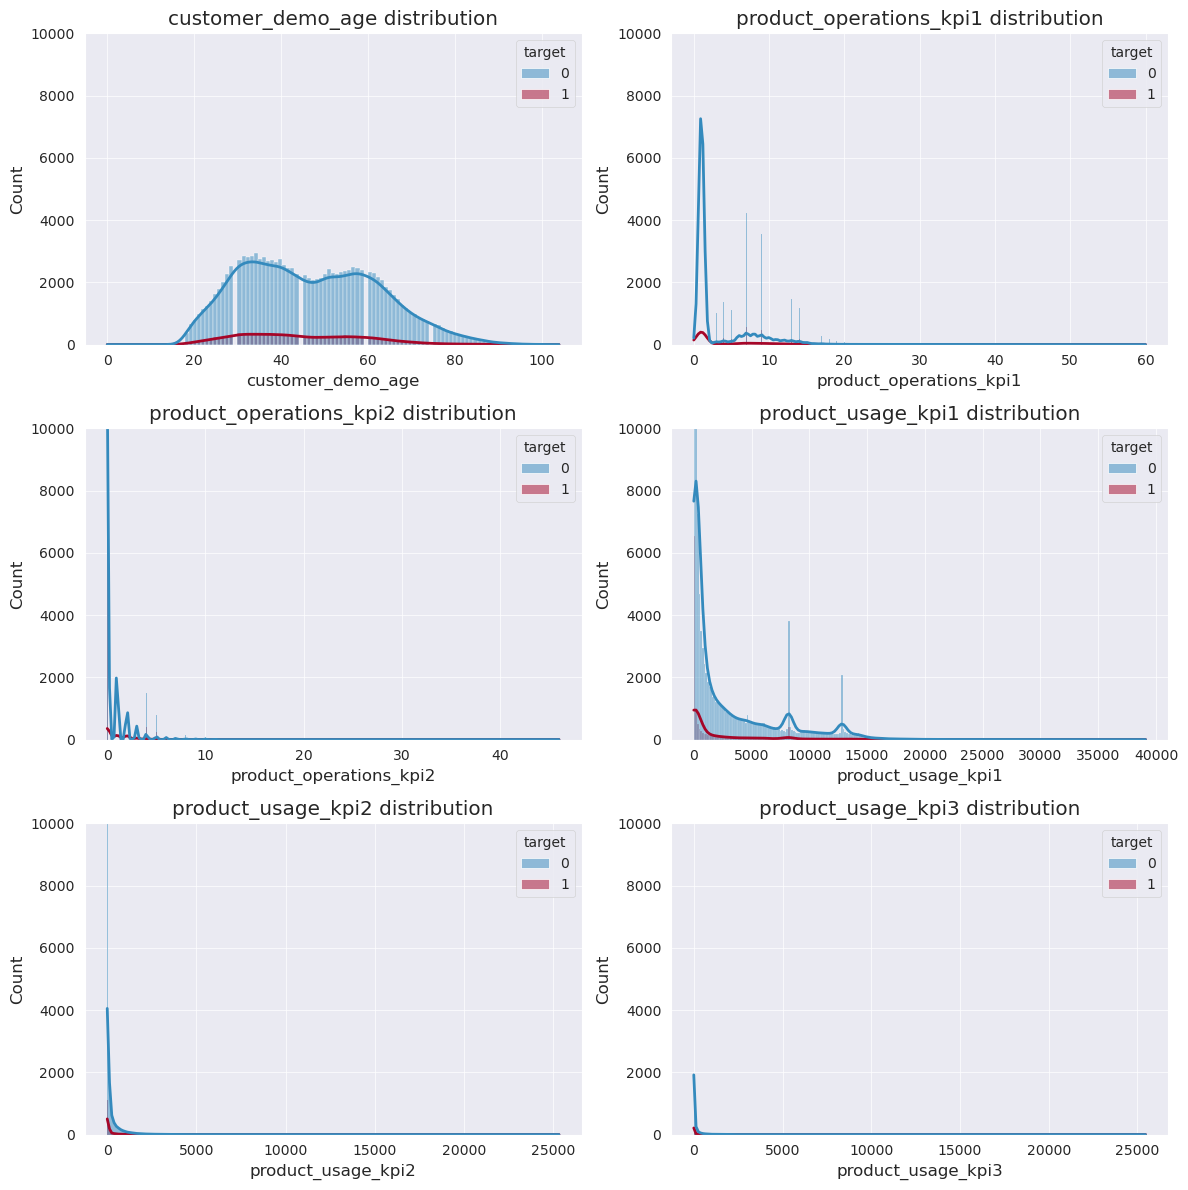

In [38]:
# Technique learned from Kaggle, but I can't find the author to cite.

def plot_distribution(df, hue, title=''):
    sns.set_style('darkgrid')
    n_cols = 2
    n_rows = (len(feature_con) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4*n_rows))

    for i, var_name in enumerate(feature_con):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue)
        ax.set_title(f'{var_name} distribution')
        ax.set_ylim(0, 10000)

    plt.tight_layout()
    plt.show()

plot_distribution(df_pre, hue = df_pre['target'], title='Raw Data')

Data has significant inbalance for the dependant/target varabile. (boolean for the account status where 1 = churn, and 0 = active). There are also outlier in some of the features. These will need to be addressed before running the models.

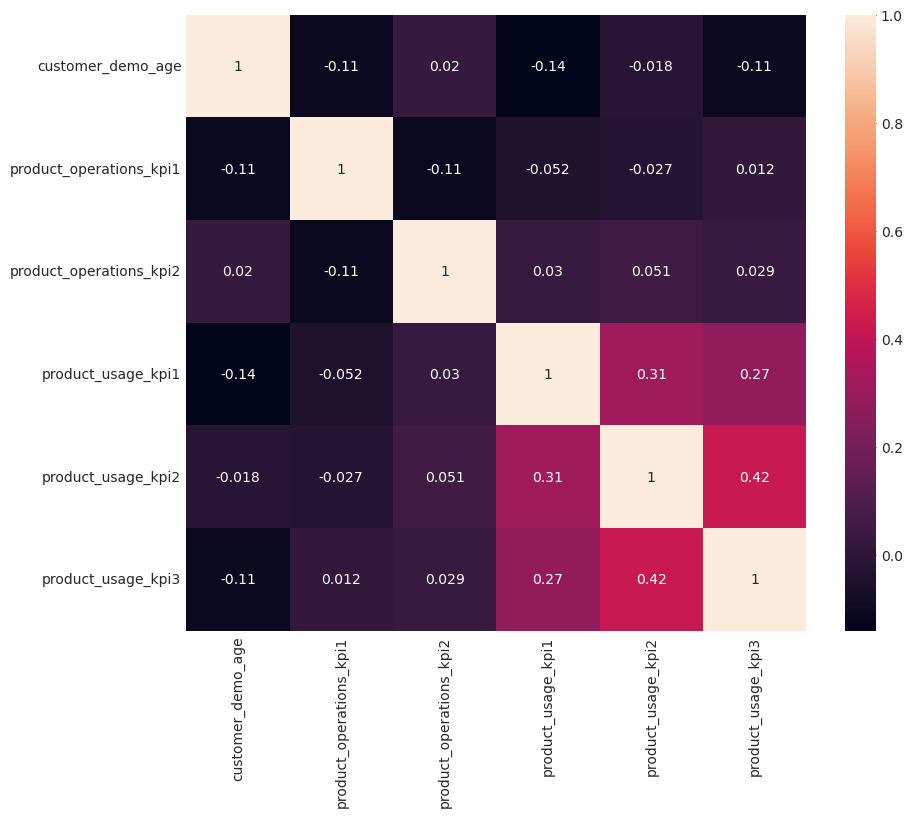

In [39]:
# Collinearity: Pearson

df_num = df_pre[feature_con]

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

corrMatrix = df_num.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [40]:
# Collinearity: VIF

df_num = df_pre[feature_con]

# Calculate VIF for each numeric feature
vif = pd.DataFrame()
vif["Feature"] = df_num.columns
vif["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

# Print the VIF values to identify multicollinearity among numeric features
print("VIF Values for Numeric Features:")
print(vif)

VIF Values for Numeric Features:
                   Feature       VIF
0        customer_demo_age  1.962145
1  product_operations_kpi1  1.443920
2  product_operations_kpi2  1.206924
3       product_usage_kpi1  1.563405
4       product_usage_kpi2  1.534980
5       product_usage_kpi3  1.363490


In [41]:
df_pre.head()

,target,customer_demo_age,customer_demo_geography,sales_channel,sales_team,sales_program,product_sku,product_cpe,product_operations_kpi1,product_operations_kpi2,product_usage_kpi1,product_usage_kpi2,product_usage_kpi3
0,0,51,37,0,16,13,2,13,1,0,557,45,3
1,0,41,37,0,16,8,2,7,1,0,4084,139,14
2,0,91,3,1,4,12,2,7,14,0,341,679,3
3,0,65,37,0,16,8,2,7,1,0,5,13,3
4,0,48,37,0,16,8,2,7,1,0,6041,168,141


Features appear to be largely independent as shown by Pearson and VIF.

## Prepare Dataset

In [42]:
# Normalize continuous features
columns_to_norm = ['product_usage_kpi1','product_usage_kpi2', 'product_usage_kpi3','product_operations_kpi1','product_operations_kpi2']

for column in columns_to_norm:
  df_pre[column] = df_pre[column] / df_pre[column].abs().max()

# Bin age into generations
# Assumption is that trends fall along generations more than specific ages
# https://www.beresfordresearch.com/age-range-by-generation/

df_pre['customer_demo_age_gen'] = df_pre['customer_demo_age'].apply(lambda age:
    'gen_z' if age >= 12 and age <= 27 else
    'millennial' if age >= 28 and age <= 43 else
    'gen_x' if age >= 44 and age <= 59 else
    'boomers' if age >= 60 and age <= 78 else
    'post_war' if age >= 79 and age <= 96 else
    'invalid' if age < 18 and age > 99 else
    'other'
)

# Drop age
# df_pre.drop('customer_demo_age', axis=1, inplace=True)


# Flatten categorical features
categorical_features = ['product_sku','sales_channel','sales_team','product_cpe','sales_program','customer_demo_age_gen','customer_demo_geography']

# Perform one-hot encoding (flattening) of the specified columns
df_pre = pd.get_dummies(df_pre, columns=categorical_features)

# Convert boolean values to integers (1 and 0)
df_pre = df_pre.astype(int)

### Feature Reduction

In [43]:
# Initial feature counts

unique_column_names = set(df_pre.columns)
column_count = len(unique_column_names)
print(f"Total Features: {column_count}")

Total Features: 130


In [44]:
# Perform ANOVA test to reduce features

from scipy.stats import f_oneway

alpha = 0.05
anova_results = []
features_to_drop = []
target_variable = 'target'

for feature_column in df_pre.columns:
    if feature_column != target_variable:
        # Group data by target variable and perform ANOVA
        grouped_data = [group[1] for group in df_pre.groupby(target_variable)[feature_column]]
        f_statistic, p_value = f_oneway(*grouped_data)
        if p_value >= alpha:
            significance = 'Not Significant'
            features_to_drop.append(feature_column)
        else:
            significance = 'Significant'

        # Store the results
        anova_results.append([feature_column, f_statistic, p_value, significance])

# Drop non-significant features
df_pre.drop(columns=features_to_drop, inplace=True)

In [45]:
# Additional feature reduction with Recursive Feature Elimination (RFE)

from sklearn.tree import DecisionTreeClassifier

# Extract the target variable and create X and y
y = df_pre['target']
X = df_pre.drop(columns=['target'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Specify the number of features to select (you can adjust this)
num_features_to_select = 12

# Create the RFE model
rfe = RFE(estimator=clf, n_features_to_select=num_features_to_select)

# Fit the RFE model to the training data
rfe.fit(X_train, y_train)

# Get the selected feature names
selected_feature_names = X.columns[rfe.support_]

# Print the names of the selected features
print("Selected feature names:", selected_feature_names.tolist())

# Filter both the training and test sets using the selected features
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Train and evaluate your model using the selected features and the test data
clf.fit(X_train_selected, y_train)
accuracy = clf.score(X_test_selected, y_test)
print(f"Accuracy on test data with selected features: {accuracy:.2f}")

# Create a final DataFrame including the selected features and the target variable
df_final = df_pre[selected_feature_names].copy()
df_final['target'] = y


Selected feature names: ['customer_demo_age', 'product_sku_0', 'product_sku_2', 'sales_channel_0', 'sales_team_3', 'product_cpe_6', 'product_cpe_7', 'sales_program_8', 'sales_program_13', 'sales_program_18', 'customer_demo_geography_3', 'customer_demo_geography_32']
Accuracy on test data with selected features: 0.90


In [46]:
# Feature count after reduction

unique_column_names = set(df_final.columns)
column_count = len(unique_column_names)
print(f"Total Features: {column_count}")

Total Features: 13


### Class Imbalance

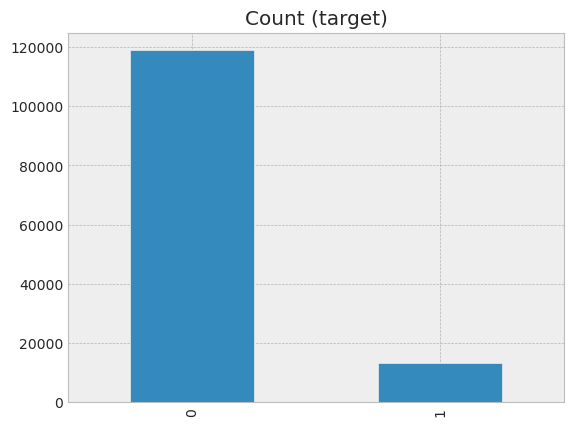

<Figure size 1000x800 with 0 Axes>

In [47]:
# Address class imbalance of the target

df_final.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

Random over-sampling:
0    118901
1    118901
Name: target, dtype: int64


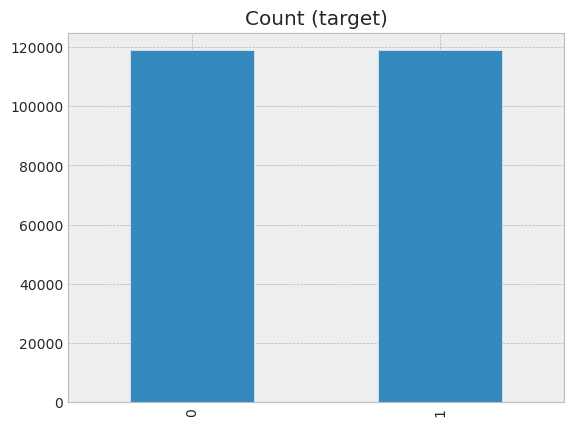

<Figure size 1000x800 with 0 Axes>

In [48]:
# Oversample the minority class using "random over sampling"
# This linear approach supports cleaner interpretation of
# feature importance.

count_class_0, count_class_1 = df_final.target.value_counts()

# Divide by class

df_class_0 = df_final[df_final['target'] == 0] #majority class

df_class_1 = df_final[df_final['target'] == 1] #minority class

df_class_1_over = df_class_1.sample(count_class_0, replace=True)

df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')

print(df_over.target.value_counts())

df_over.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')

plt.figure(figsize=(10, 8))

plt.show()

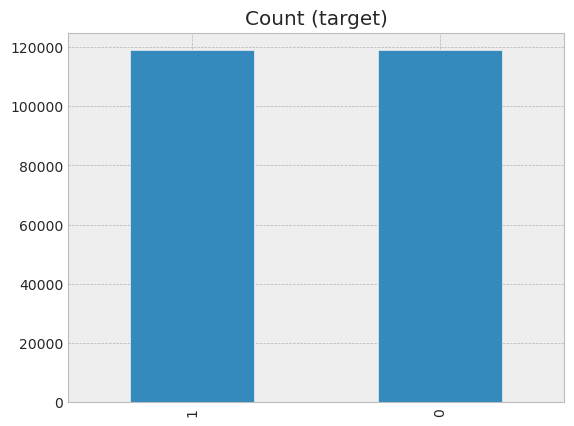

In [49]:
# Shuffle the array before train/test split

df_over = shuffle(df_over,random_state=0)
df_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [50]:
# Train/test splits

X, y = df_over, df_over.pop("target")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=888)

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190241 entries, 125549 to 1588
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   customer_demo_age           190241 non-null  int64
 1   product_sku_0               190241 non-null  int64
 2   product_sku_2               190241 non-null  int64
 3   sales_channel_0             190241 non-null  int64
 4   sales_team_3                190241 non-null  int64
 5   product_cpe_6               190241 non-null  int64
 6   product_cpe_7               190241 non-null  int64
 7   sales_program_8             190241 non-null  int64
 8   sales_program_13            190241 non-null  int64
 9   sales_program_18            190241 non-null  int64
 10  customer_demo_geography_3   190241 non-null  int64
 11  customer_demo_geography_32  190241 non-null  int64
dtypes: int64(12)
memory usage: 18.9 MB


## Model Comparison

### Logistic Regression

In [52]:
# Create model

from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000)  # Increase max_iter to 1000 or more for AWS

In [53]:
# Fit and score the model

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.70      0.73     23844
           1       0.72      0.77      0.74     23717

    accuracy                           0.74     47561
   macro avg       0.74      0.74      0.74     47561
weighted avg       0.74      0.74      0.74     47561



C=0.0001, train: 0.721, test: 0.718
C=0.0003, train: 0.732, test: 0.731
C=0.0007, train: 0.737, test: 0.737
C=0.0018, train: 0.739, test: 0.738
C=0.0048, train: 0.738, test: 0.736
C=0.0127, train: 0.738, test: 0.736
C=0.0336, train: 0.738, test: 0.736
C=0.0886, train: 0.738, test: 0.736
C=0.2336, train: 0.738, test: 0.736
C=0.6158, train: 0.738, test: 0.736
C=1.6238, train: 0.738, test: 0.736
C=4.2813, train: 0.738, test: 0.736
C=11.2884, train: 0.738, test: 0.736
C=29.7635, train: 0.738, test: 0.736
C=78.4760, train: 0.738, test: 0.736
C=206.9138, train: 0.738, test: 0.736
C=545.5595, train: 0.738, test: 0.736
C=1438.4499, train: 0.738, test: 0.736
C=3792.6902, train: 0.738, test: 0.736
C=10000.0000, train: 0.738, test: 0.736


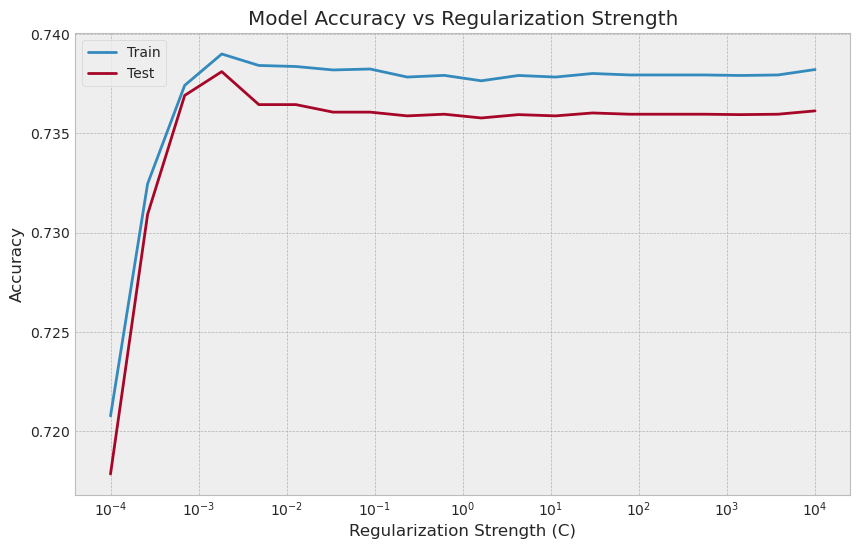

In [54]:
# Look for overfitting

# Define the regularization strengths to evaluate
C_values = np.logspace(-4, 4, 20)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each regularization strength
for C in C_values:

    # Configure the model
    model_lr = LogisticRegression(penalty='l2', C=C, max_iter=1000)

    # Fit model on the training dataset
    model_lr.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_lr.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_lr.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('C=%.4f, train: %.3f, test: %.3f' % (C, train_acc, test_acc))

# Plot of train and test scores vs regularization strength
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_scores, label='Train')
plt.semilogx(C_values, test_scores, label='Test')
plt.title('Model Accuracy vs Regularization Strength')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Set y-axis formatter
plt.legend()
plt.show()

In [55]:
# Get model parameters

for parameter in model_lr.get_params():
    print(parameter)

C
class_weight
dual
fit_intercept
intercept_scaling
l1_ratio
max_iter
multi_class
n_jobs
penalty
random_state
solver
tol
verbose
warm_start


In [56]:
# Define hyperparameter dictionary and run a grid search

param_dict = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize Logistic Regression
log_reg = LogisticRegression()

# Set up GridSearchCV
grid = GridSearchCV(estimator=log_reg,
                    param_grid=param_dict,
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

# Fit GridSearchCV to the training data
grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=1)

In [57]:
# Extract the best preforming hyper-parameter values

grid.best_params_

# Results
# {'C': 0.0018329807108324356, 'penalty': 'l1', 'solver': 'liblinear'}

{'C': 0.0018329807108324356, 'penalty': 'l1', 'solver': 'liblinear'}

In [58]:
# Update model

model_lr_u=LogisticRegression(C = 0.0007,
                                   penalty ='l2',
                                   solver = 'liblinear')

In [59]:
#Fit and re-score the model

model_lr_u.fit(X_train, y_train)


y_pred = model_lr_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     23844
           1       0.72      0.77      0.74     23717

    accuracy                           0.74     47561
   macro avg       0.74      0.74      0.73     47561
weighted avg       0.74      0.74      0.73     47561



Churn: ROC AUC=0.500
Logistic: ROC AUC=0.792


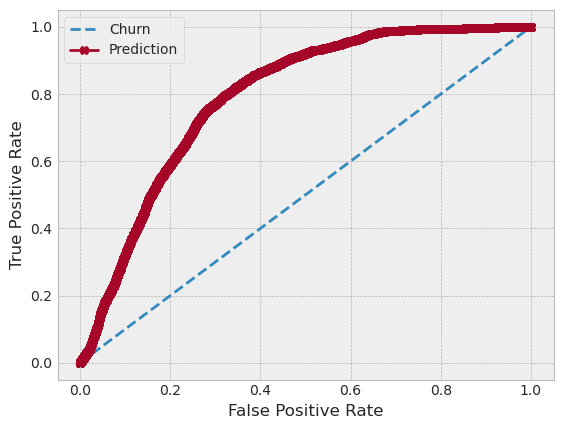

In [60]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_lr_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [61]:
# Get the feature weights (coefficients)
weights_lr = model_lr.coef_[0]

# Create a DataFrame for easy viewing
importance_lr = pd.DataFrame({'Feature': X_train.columns, 'Weight': weights_lr})
print(importance_lr)

                       Feature    Weight
0            customer_demo_age -0.008509
1                product_sku_0  0.728968
2                product_sku_2 -2.337063
3              sales_channel_0 -0.311111
4                 sales_team_3  0.488463
5                product_cpe_6 -1.168377
6                product_cpe_7 -0.133369
7              sales_program_8 -0.468692
8             sales_program_13 -0.653166
9             sales_program_18 -0.546737
10   customer_demo_geography_3  0.144200
11  customer_demo_geography_32  0.130899


### Decision Tree Classification

In [62]:
# Create model

from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()

In [63]:
# Fit and score the model

model_dt.fit(X_train, y_train)

y_pred = model_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.73      0.76     23844
           1       0.75      0.80      0.78     23717

    accuracy                           0.77     47561
   macro avg       0.77      0.77      0.77     47561
weighted avg       0.77      0.77      0.77     47561



>1, train: 0.72, test: 0.71
>2, train: 0.74, test: 0.73
>3, train: 0.74, test: 0.74
>4, train: 0.75, test: 0.75
>5, train: 0.75, test: 0.75
>6, train: 0.75, test: 0.75
>7, train: 0.75, test: 0.75
>8, train: 0.75, test: 0.75
>9, train: 0.75, test: 0.75
>10, train: 0.75, test: 0.75


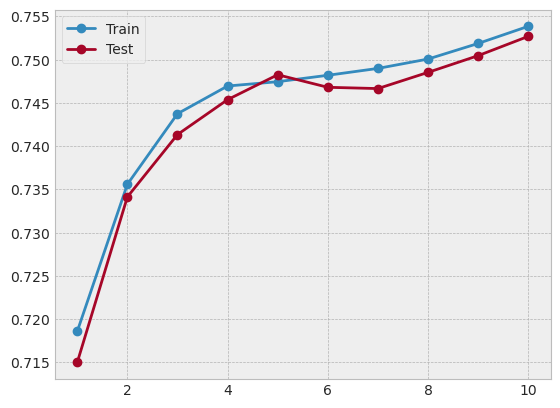

In [64]:
# Look for overfitting

# Define the tree depths to evaluate
values = [i for i in range(1, 11)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_dt = DecisionTreeClassifier(max_depth=i, random_state=42)

    # fit model on the training dataset
  model_dt.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_dt.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_dt.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.2f, test: %.2f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [65]:
# Get model parameters

model_dt = DecisionTreeClassifier()
for parameter in model_dt.get_params():
    print(parameter)

ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
monotonic_cst
random_state
splitter


In [66]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

param_dict = {'criterion' :['gini', 'entropy'],
            'max_depth' :range(1,11),
            'min_samples_split': [20, 50],
            'min_samples_leaf': [20, 50],
            'ccp_alpha': [0.0001, 0.001]
              }

tree_class = DecisionTreeClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 5,
        verbose= 1,
        n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 11),
                         'min_samples_leaf': [20, 50],
                         'min_samples_split': [20, 50]},
             verbose=1)

In [67]:
# Extact the best preforming hyper-parameter values

grid.best_params_

# Results

#{'ccp_alpha': 0.0001,
# 'criterion': 'entropy',
# 'max_depth': 8,
# 'min_samples_leaf': 20,
# 'min_samples_split': 20}

{'ccp_alpha': 0.0001,
 'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 50,
 'min_samples_split': 20}

In [68]:
# Update model

model_dt_u=DecisionTreeClassifier(ccp_alpha = 0.0001,
                                   criterion ='entropy',
                                   max_depth = 7,
                                   min_samples_leaf = 50,
                                   min_samples_split = 20
                                   )

In [69]:
#Fit and re-score the model

model_dt_u.fit(X_train, y_train)


y_pred = model_dt_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.71      0.74     23844
           1       0.73      0.79      0.76     23717

    accuracy                           0.75     47561
   macro avg       0.75      0.75      0.75     47561
weighted avg       0.75      0.75      0.75     47561



>1, train: 0.719, test: 0.715
>2, train: 0.736, test: 0.734
>3, train: 0.744, test: 0.741
>4, train: 0.747, test: 0.745
>5, train: 0.747, test: 0.748
>6, train: 0.748, test: 0.747
>7, train: 0.749, test: 0.747


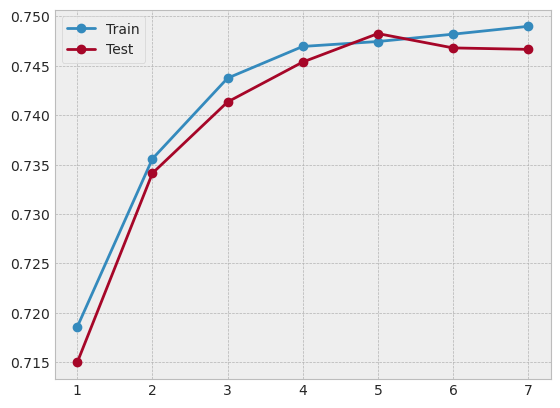

In [70]:
# Look again for overfitting

# Define the tree depths to evaluate
values = [i for i in range(1, 8)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_dt_u = DecisionTreeClassifier(max_depth=i, random_state=888)

    # fit model on the training dataset
  model_dt_u.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_dt_u.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_dt_u.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

Churn: ROC AUC=0.500
Logistic: ROC AUC=0.824


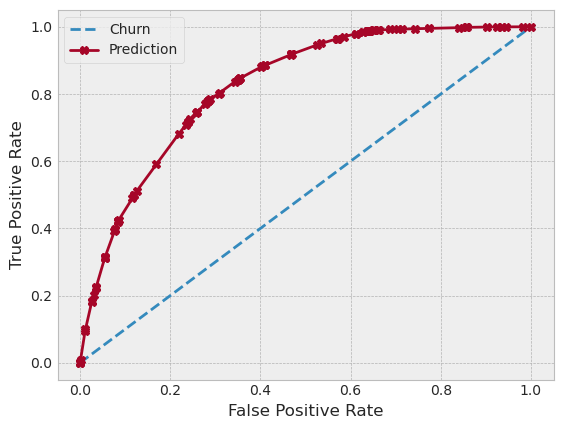

In [71]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_dt_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [72]:
# Get the feature importance

importance_dt = model_dt_u.feature_importances_

# Create a DataFrame for easy viewing
importance_dt = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_dt})
print(importance_dt)

                       Feature  Importance
0            customer_demo_age    0.028586
1                product_sku_0    0.006039
2                product_sku_2    0.680248
3              sales_channel_0    0.017821
4                 sales_team_3    0.008702
5                product_cpe_6    0.127314
6                product_cpe_7    0.001568
7              sales_program_8    0.004092
8             sales_program_13    0.000395
9             sales_program_18    0.002851
10   customer_demo_geography_3    0.121608
11  customer_demo_geography_32    0.000777


### Random Forrest Classifier

In [73]:
# Create model

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()

In [74]:
# Fit and score the model

model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.73      0.76     23844
           1       0.75      0.81      0.78     23717

    accuracy                           0.77     47561
   macro avg       0.77      0.77      0.77     47561
weighted avg       0.77      0.77      0.77     47561



Max depth: 1, Train Accuracy: 0.669, Test Accuracy: 0.666
Max depth: 2, Train Accuracy: 0.708, Test Accuracy: 0.705
Max depth: 3, Train Accuracy: 0.729, Test Accuracy: 0.726
Max depth: 4, Train Accuracy: 0.739, Test Accuracy: 0.738
Max depth: 5, Train Accuracy: 0.747, Test Accuracy: 0.744
Max depth: 6, Train Accuracy: 0.747, Test Accuracy: 0.746
Max depth: 7, Train Accuracy: 0.749, Test Accuracy: 0.747
Max depth: 8, Train Accuracy: 0.750, Test Accuracy: 0.749
Max depth: 9, Train Accuracy: 0.753, Test Accuracy: 0.752
Max depth: 10, Train Accuracy: 0.757, Test Accuracy: 0.755


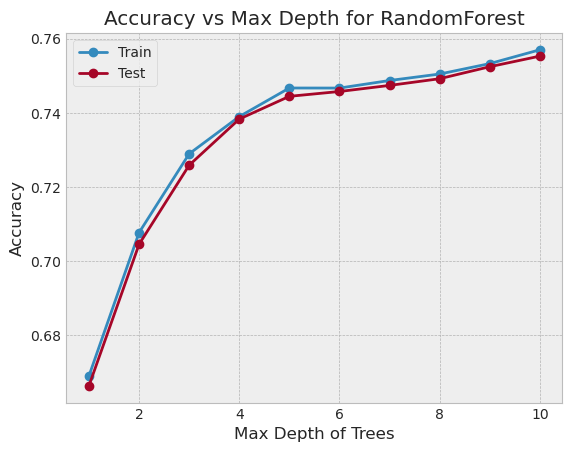

In [75]:
# Look for overfitting

# Define the tree depths to evaluate
values = range(1, 11)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model with the current max_depth
    model_rf = RandomForestClassifier(max_depth=i, random_state=42)

    # Fit the model to the training data
    model_rf.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_rf.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for RandomForest')
plt.legend()
plt.show()


In [76]:
# Get model parameters

for parameter in model_rf.get_params():
    print(parameter)

bootstrap
ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
max_samples
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
monotonic_cst
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [ ]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

param_dict = {
    "criterion": ["gini", "entropy"],
    "max_depth" : range(1, 11),
    'min_samples_split': [20, 50],
    'min_samples_leaf': [20, 50],
    #'max_features': ['auto'], While this worked in Colab, it's causing an error in AWS
    'ccp_alpha': [0.0001, 0.001]
}

tree_class = RandomForestClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 5,
        verbose= 1,
        n_jobs = -1)

grid.fit(X_train, y_train)

In [ ]:
# Extact the best preforming hyper-parameter values

grid.best_params_

# Results
# {'ccp_alpha': 0.0001,
# 'criterion': 'entropy',
# 'max_depth': 8,
# 'max_features': 'auto',
# 'min_samples_leaf': 50,
# 'min_samples_split': 20}

In [ ]:
# Update model

model_rf_u = RandomForestClassifier(
                                  ccp_alpha = 0.001,
                                   criterion ='entropy',
                                   max_depth = 8,
                                   max_features = 'auto',
                                   min_samples_leaf = 50,
                                   min_samples_split = 20)

In [ ]:
#Fit and re-score the model

model_rf_u.fit(X_train, y_train)

y_pred = model_rf_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
# Look again for overfitting

# Define the tree depths to evaluate
values = range(1, 11)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model with the current max_depth
    model_rf_u = RandomForestClassifier(max_depth=i, random_state=888)

    # Fit the model to the training data
    model_rf_u.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_rf_u.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_rf_u.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for RandomForest')
plt.legend()
plt.show()


In [ ]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_rf_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [ ]:
# Get the feature importance
importance_rf = model_rf.feature_importances_

# Create a DataFrame for easy viewing
importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_rf})
print(importance_rf)

## Gradient Boost

In [78]:
# Create model

from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier()

In [79]:
# Fit and score the model

model_gb.fit(X_train, y_train)

y_pred = model_gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.69      0.73     23844
           1       0.72      0.80      0.76     23717

    accuracy                           0.75     47561
   macro avg       0.75      0.75      0.75     47561
weighted avg       0.75      0.75      0.75     47561



In [ ]:
# Look for overfitting

# Define the tree depths to evaluate
values = range(1, 11)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Initialize the Gradient Boosting Classifier with varying max_depth
    model_gb = GradientBoostingClassifier(max_depth=i, random_state=42)

    # Fit the model to the training data
    model_gb.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_gb.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_gb.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting Model Accuracy vs Tree Depth')
plt.legend()
plt.show()


In [ ]:
# Get model parameters

for parameter in model_gb.get_params():
    print(parameter)

In [ ]:
# Potentially faster Grid Search for GB model


from sklearn.model_selection import RandomizedSearchCV

# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting
param_dict = {
    "criterion": ["friedman_mse", "squared_error"],
    "max_depth": range(1, 11),
    #'min_samples_split': [20, 50], # trying to reduce compute time
    #'min_samples_leaf': [20, 50],  # trying to reduce compute time
    'ccp_alpha': [0.0001, 0.001],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1]
}

tree_class = GradientBoostingClassifier()

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=tree_class,
                                   param_distributions=param_dict,
                                   n_iter=5, # trying to reduce compute time
                                   cv=5,
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

In [ ]:
# Extract the best preforming parameters

random_search.best_params_


#{'n_estimators': 100,
# 'max_depth': 9,
# 'learning_rate': 0.01,
# 'criterion': 'friedman_mse',
# 'ccp_alpha': 0.0001}


In [ ]:
# Update model

model_gb_u = GradientBoostingClassifier( n_estimators = 100,
                                        max_depth = 3,
                                        learning_rate = 0.01,
                                        criterion ='friedman_mse',
                                        ccp_alpha = 0.0001)

In [ ]:
#Fit and re-score the model

model_gb_u.fit(X_train, y_train)

y_pred = model_gb_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
# Look again for overfitting

# Define the tree depths to evaluate
values = range(1, 10)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model with the current max_depth
    model_gb_u = RandomForestClassifier(max_depth=i, random_state=888)

    # Fit the model to the training data
    model_gb_u.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_gb_u.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_gb_u.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for RandomForest')
plt.legend()
plt.show()

In [ ]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# fit a model
model_gb_u.fit(X_train, y_train.values)

# predict probabilities
lr_probs = model_gb_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [ ]:
# Get the feature importance
importance_gb = model_gb_u.feature_importances_

# Create a DataFrame for easy viewing
importance_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_gb})
print(importance_gb)

## Feature Importance

Shape of shap_values: (47561, 12, 2)


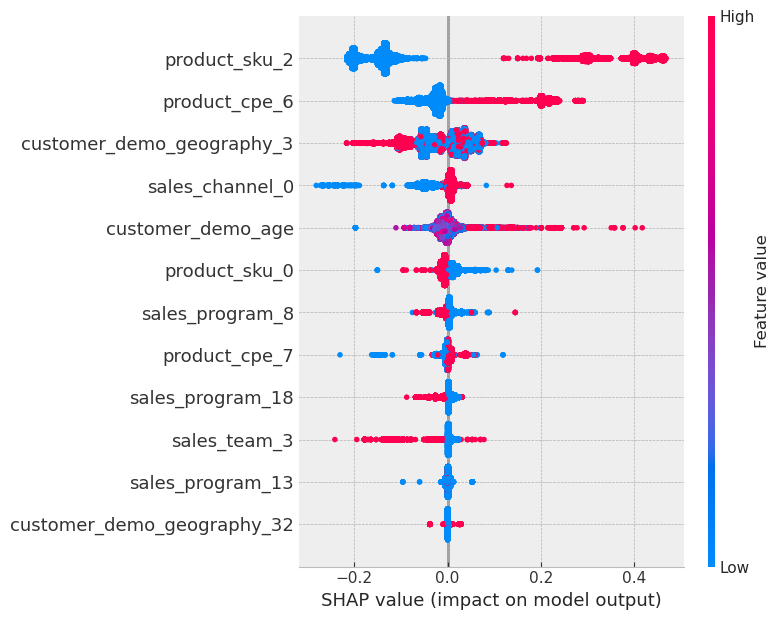

In [99]:
import shap
import matplotlib.pyplot as plt

# Fit the model
model_dt_u.fit(X_train, y_train)

# Explain the model predictions using SHAP
explainer = shap.TreeExplainer(model_dt_u)
shap_values = explainer.shap_values(X_test)

# Check the shape of shap_values to verify the structure
print(f"Shape of shap_values: {shap_values.shape}")

# Generate the summary plot for one of the classes, let's use the first class (index 0)
shap.summary_plot(shap_values[:, :, 0], X_test)

# Alternatively, for the second class (index 1), use:
# shap.summary_plot(shap_values[:, :, 1], X_test)

plt.show()


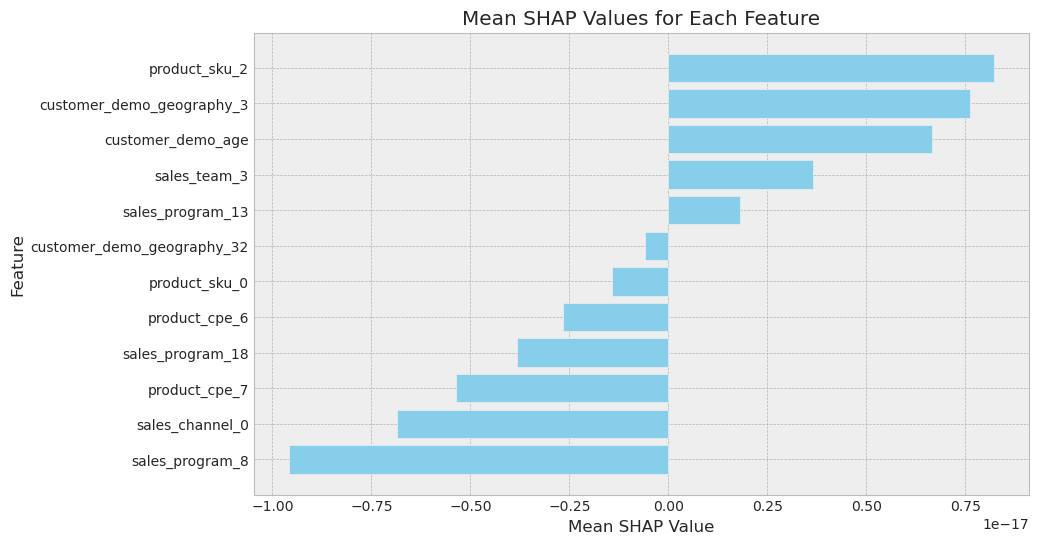

                       Feature  Min SHAP Value  Mean SHAP Value  \
7              sales_program_8       -0.144797    -9.581308e-18   
3              sales_channel_0       -0.281368    -6.850201e-18   
6                product_cpe_7       -0.230475    -5.357347e-18   
9             sales_program_18       -0.087696    -3.829870e-18   
5                product_cpe_6       -0.289931    -2.662302e-18   
1                product_sku_0       -0.192463    -1.421123e-18   
11  customer_demo_geography_32       -0.038031    -5.802776e-19   
8             sales_program_13       -0.095959     1.800476e-18   
4                 sales_team_3       -0.241433     3.651660e-18   
0            customer_demo_age       -0.416690     6.662934e-18   
10   customer_demo_geography_3       -0.216353     7.605290e-18   
2                product_sku_2       -0.468012     8.211679e-18   

    Max SHAP Value  
7         0.144797  
3         0.281368  
6         0.230475  
9         0.087696  
5         0.289931  
1 

In [102]:

# Initialize an empty list to store feature statistics
feature_stats = []
feature_to_drop = []

# Loop through each feature and calculate min, mean, and max SHAP values
for i in range(len(X_test.columns)):
    feature_name = X_test.columns[i]
    shap_values_feature = shap_values[:, i]
    min_val = np.min(shap_values_feature)
    mean_val = np.mean(shap_values_feature)
    max_val = np.max(shap_values_feature)
    feature_stats.append([feature_name, min_val, mean_val, max_val])
    
    # Append the statistics to the list of features to drop
    if min_val == mean_val == max_val == 0:
        feature_to_drop.append([feature_name, min_val, mean_val, max_val])

# Create DataFrames of all features with their min, mean, max values
feature_stats_df = pd.DataFrame(feature_stats, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Save the DataFrame to the specified path as a CSV file
csv_path = 'feature_stats.csv'
feature_stats_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column

# Create a DataFrame of dropped features
feature_to_drop_df = pd.DataFrame(feature_to_drop, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Save the DataFrame to the specified path as a CSV file
csv_path = 'feature_to_drop_df.csv'
feature_to_drop_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column

# Plotting the mean SHAP values for each feature
plt.figure(figsize=(10, len(feature_stats_df) / 2))  # Adjust the figure size as needed
feature_stats_df.sort_values(by='Mean SHAP Value', ascending=True, inplace=True)
plt.barh(feature_stats_df['Feature'], feature_stats_df['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Values for Each Feature')
plt.show()

print(feature_stats_df)

<Figure size 4000x1000 with 0 Axes>

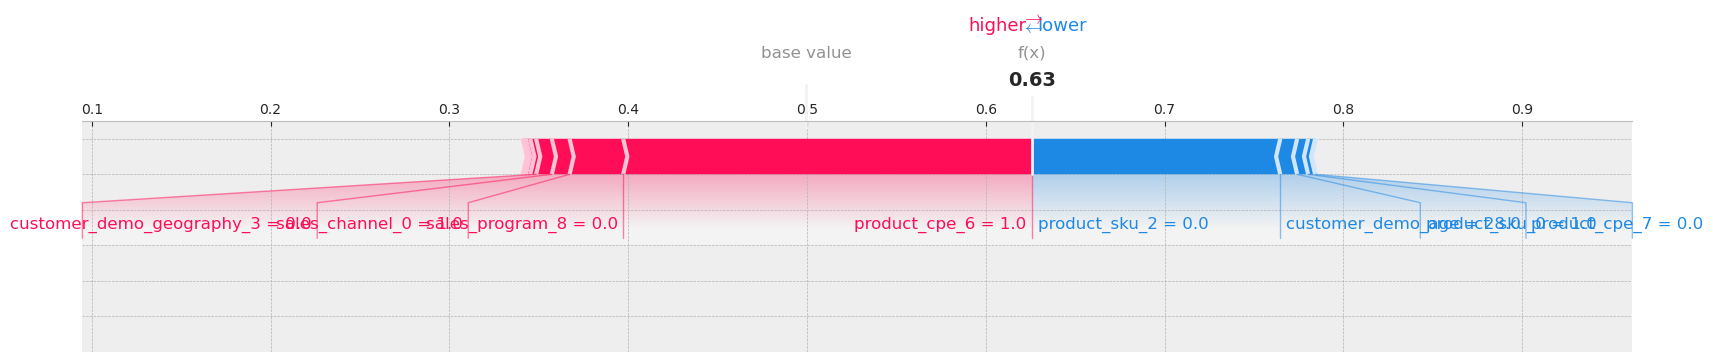

<Figure size 4000x1000 with 0 Axes>

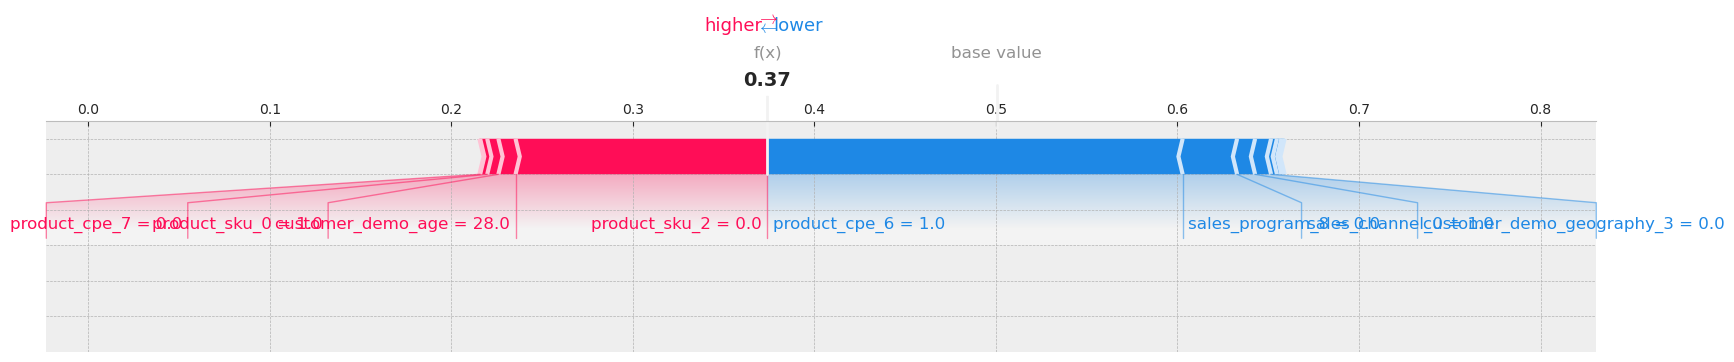

In [104]:
# Force Plot visualization: single customer (Local SHAP values)

# Calculate SHAP values for the first row of the X_test dataset
shap_values_single = exp.shap_values(X_test.iloc[58]) # Good Example of really bad churn

# Initialize JavaScript visualization in Google Colab (even if it might not display)
shap.initjs()

# Generate a force plot using matplotlib backend for the first class
plt.figure(figsize=(40, 10)) 
shap.force_plot(exp.expected_value[0], shap_values_single[:, 0], X_test.iloc[58], feature_names=X_test.columns, matplotlib=True) 
plt.show()

# Generate a force plot using matplotlib backend for the second class
plt.figure(figsize=(40, 10)) 
shap.force_plot(exp.expected_value[1], shap_values_single[:, 1], X_test.iloc[58], feature_names=X_test.columns, matplotlib=True) 
plt.show()

## Model Interpretation and Conclusions

All models resulted in similar findings for recall, percision and F1. However, Random Forrest and Gradient Boosted Classification models had compute needs that made them problematic to run and tune. Logistic Regression was fast, but those models may not capture how features interact with each other (assumes a linear relationship between features and target). Feature combination effects are shown in SHAP plots. When a Decision Tree Classifier was property tuned, its' tendency to overfit was controlled. As it is fast, captures feature combination effects and tends to be more interetable to stake holders, Decision Tree Classifier is my model of choice for this exercise.

"product_sku_2" consistently showed itself to be the most powerful indicator of churn, trumping all other features. The conclusion is that this feature is the "tide that raises all ships" and one that can be implemented broadly. In my commercial implementation of these findings, it was the primary focus for mitigating churn and resulted in a > 15% reduction in measured monthly churn.

Other impactful features include a specific model of Customer Premise Equipment ("product_cpe_6"). Engineering and Product teams should examine how this CPE differs from the other models to see if different key components are having an unexpected experiential impact.

Having said that, an examination of the interaction between the complete set of features for a particular customer, including demographic, sales channel, customer premise equipment and kpis shows that "product_sku" and "product_cpe" are only a portion of the story. It should not be conclude that these alone will nullify any/all other factors for a particular customer.